# Hyperparameter transfer matrix

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# special import (so that ReczillaClassifier can be imported)
import os
import sys
HOME = os.environ.get("HOME")
sys.path.insert(0, f"{HOME}/reczilla/RecSys2019_DeepLearning_Evaluation")

In [3]:
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, precision_score
from sklearn.multioutput import RegressorChain
import xgboost as xgb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


from ReczillaClassifier.get_alg_feat_selection_data import get_metafeats, compute_feature_corrs
# alg_feature_selection_featurized, 
from ReczillaClassifier.dataset_families import get_all_datasets

In [10]:
# constants

METRICS = ["PRECISION_cut_10", "MAP_cut_10"]
# todo: do we need to add 'test_metric' here?
ALL_DATASETS = list(get_all_datasets())
METADATASET_NAME = "metadata-v2"

metric = METRICS[0]
result_folder = 'plots_dev/'

default_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                  (1.0, 0.4980392156862745, 0.054901960784313725),
                  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                  (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                  (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
                  (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
                  (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
                  (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                  (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
                  (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                  (0.0, 0.0, 0.0)
                 ]

In [11]:
#metric = 'time_on_train'
metric = "test_metric_PRECISION_cut_10"
meta_dataset = get_metafeats(METADATASET_NAME)
#feature_corrs = compute_feature_corrs(meta_dataset, [], metric, selected_algs=None)

In [14]:
# hpo transfer matrix
"""
Given algorithm A,
entry [i,j] is the regret of A when hyperparams are trained on dataset i and evaluated on dataset j.
"""

def compute_matrix(alg_family, datasets, failure_threshold=3):
    alg_dataset = meta_dataset[(meta_dataset['alg_family'] == alg_family)]
    
    matrix = np.zeros((len(datasets), len(datasets)))

    # manually set the diagonal to 1's since the for loop will not include the diagonal
    for i in range(len(datasets)):
        matrix[i][i] = 1
    
    no_data_entries = []
    success_count = 0
    
    for i, j in itertools.combinations(range(len(datasets)), 2):
        dataset_i = datasets[i]
        dataset_j = datasets[j]

        # compute a list of all seeds that completed on both
        result_pairs = []
        for hpo_seed in range(100):
            # todo: this excludes all ItemKNNCF/UserKNNCF results
            alg_param_name = alg_family + ':random_' + str(hpo_seed)
            results_i = alg_dataset[(alg_dataset['alg_param_name'] == alg_param_name) & (alg_dataset['dataset_name'] == dataset_i)]
            results_j = alg_dataset[(alg_dataset['alg_param_name'] == alg_param_name) & (alg_dataset['dataset_name'] == dataset_j)]
            if len(results_i) > 0 and len(results_j) > 0:
                result_i = results_i['test_metric_' + metric].iloc[0]
                result_j = results_j['test_metric_' + metric].iloc[0]
                result_pairs.append((result_i, result_j))

        if len(result_pairs) < failure_threshold:
            no_data_entries.append((i,j))
            #print(i,j, 'only', len(result_pairs))
            continue

        result_pairs = np.array(result_pairs).T

        # min max scaling
        for n in range(2):
            minimum, maximum = np.min(result_pairs[n]), np.max(result_pairs[n])
            if maximum - minimum > 0.000001:
                result_pairs[n] = [(m - minimum) / (maximum - minimum) for m in result_pairs[n]]

        #print(result_pairs)

        # best i computed on j, and vice versa
        matrix[i][j] = result_pairs[0][np.argmax(result_pairs[1])]
        matrix[j][i] = result_pairs[1][np.argmax(result_pairs[0])]
        success_count += 1

    # for all i,j that did not have enough shared hyperparams finish
    #avg_value = np.mean(matrix)
    avg_value = .5
    for i,j in no_data_entries:
        matrix[i][j] = avg_value
        matrix[j][i] = avg_value
        
    failure_rate = len(no_data_entries) / (len(no_data_entries)+success_count)
    print(alg_family, failure_rate, 'failure_rate')
    if failure_rate < .35:
        return matrix

def plot_matrix(matrix, alg_family, datasets, save=None, cmap='viridis', hparam=False):
    cellsize = 5
    fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*matrix.shape[0]/matrix.shape[1]))
    im = ax.pcolormesh(matrix, edgecolor='k', linewidth=0.5, cmap=cmap) 
    plt.title('HParam. Transfer: ' + alg_family)
    plt.gca().invert_yaxis()
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xticks([c+0.5 for c in range(matrix.shape[0]-0)], minor=True)
    
    dataset_labels = [d[:-6] for d in datasets]
    
    ax.set_xticklabels(dataset_labels, minor=True, rotation=90)
    ax.set_yticks([])
    ax.set_yticklabels('')    
    ax.set_yticks([c+0.5 for c in range(matrix.shape[1]-0)], minor=True)
    ax.set_yticklabels(dataset_labels, minor=True)
    fig.colorbar(im, ax=ax)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)


PureSVDRecommender 0.0 failure_rate


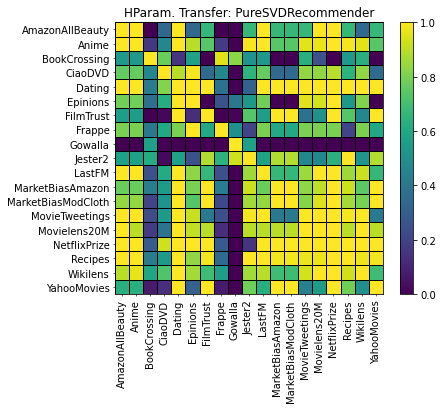

P3alphaRecommender 0.10526315789473684 failure_rate


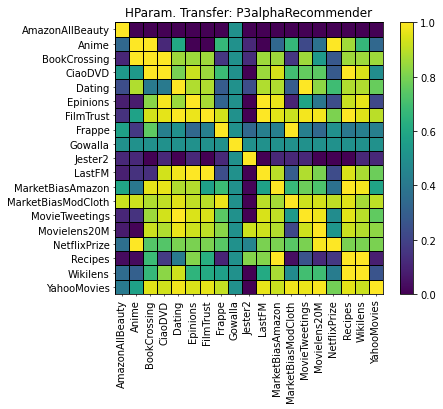

MatrixFactorization_BPR_Cython 0.10526315789473684 failure_rate


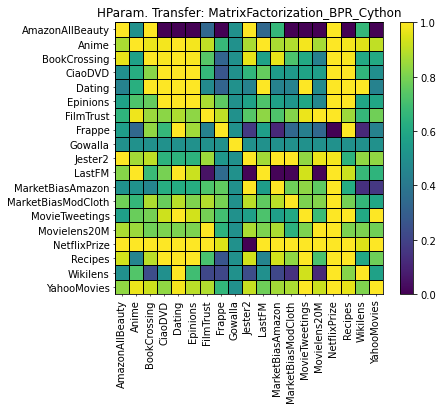

RP3betaRecommender 0.10526315789473684 failure_rate


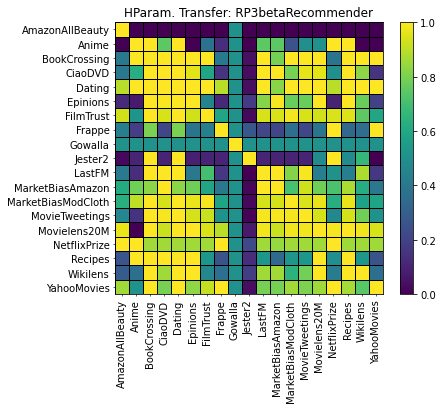

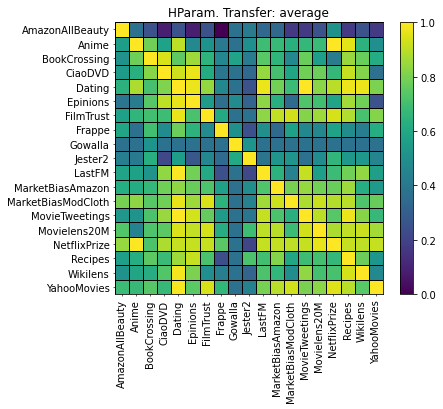

In [15]:
# TODO: currenlty algs do not include either KNNs

ABRIDGED_DATASETS = ['AmazonAllBeautyReader', 'AmazonAllElectronicsReader', 'AmazonAlternativeRockReader', 'AmazonAmazonFashionReader', 'AmazonAmazonInstantVideoReader', 'AnimeReader', 'BookCrossingReader', 'CiaoDVDReader', 'DatingReader', 'EpinionsReader', 'FilmTrustReader', 'FrappeReader', 'GowallaReader', 'Jester2Reader', 'LastFMReader', 'MarketBiasAmazonReader', 'MarketBiasModClothReader', 'MovieTweetingsReader', 'Movielens100KReader', 'Movielens10MReader', 'Movielens1MReader', 'Movielens20MReader', 'MovielensHetrec2011Reader', 'NetflixPrizeReader', 'RecipesReader', 'WikilensReader', 'YahooMoviesReader', 'YahooMusicReader']
DATASETS_ONE_PER_FAMILY = ['AmazonAllBeautyReader', 'AnimeReader', 'BookCrossingReader', 'CiaoDVDReader', 'DatingReader', 'EpinionsReader', 'FilmTrustReader', 'FrappeReader', 'GowallaReader', 'Jester2Reader', 'LastFMReader', 'MarketBiasAmazonReader', 'MarketBiasModClothReader', 'MovieTweetingsReader', 'Movielens20MReader', 'NetflixPrizeReader', 'RecipesReader', 'WikilensReader', 'YahooMoviesReader']

NON_KDD_FAMILIES = ['TopPop', 'IALSRecommender', 'SLIMElasticNetRecommender', 'Random', 'SlopeOne', 'PureSVDRecommender', 'GlobalEffects', 'SLIM_BPR_Cython', 'CoClustering', 'P3alphaRecommender', 'MatrixFactorization_BPR_Cython', 'MatrixFactorization_FunkSVD_Cython', 'EASE_R_Recommender', 'MatrixFactorization_AsySVD_Cython', 'RP3betaRecommender', 'NMFRecommender']
HIGH_SUCCESS_RATE_FAMILIES = ['PureSVDRecommender', 'P3alphaRecommender', 'MatrixFactorization_BPR_Cython', 'RP3betaRecommender']

# choose the metric, datasets, and alg_families to use:
metric = 'PRECISION_cut_10'
data = DATASETS_ONE_PER_FAMILY
alg_families = HIGH_SUCCESS_RATE_FAMILIES

matrices = []
for alg_family in alg_families:
    matrix = compute_matrix(alg_family, data)
    if matrix is not None:
        matrices.append(matrix)
        plot_matrix(matrix, alg_family, data, save=alg_family + '_matrix.pdf')
        plt.show()
        
avg_matrix = np.mean(np.array(matrices), axis=0)
plot_matrix(avg_matrix, 'average', data, save='average' + '_matrix.pdf')
plt.show()